In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import  Adam
from keras import regularizers
from keras import backend as K
from keras.layers import Convolution2D, MaxPooling2D

pd.options.mode.chained_assignment = None

### Import dataset

In [7]:
def importdata(path):
    
    df = pd.read_csv(path)
    display(df.isnull().sum())
    
    print('Number of Original Dataset : %d' % (df.shape[0]))
    df = df.dropna(axis = 0)
    print('Number of Drop NaN : %d' % (df.shape[0]))
    df = df.reset_index(drop = True)
    
    con0 = pd.DataFrame(df.Sport.str.split('x',2).tolist(), columns = ['Sport','y'])
    con1 = pd.DataFrame(df.Dport.str.split('x',2).tolist(), columns = ['Dport','w'])
    del df["Sport"]
    del df["Dport"]
    df["Sport"] = con0.Sport
    df["Dport"] = con1.Dport
    return df

In [8]:
path_trianing = "capture20110810.binetflow.txt"
df0 = importdata(path_trianing)

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          9379
Dir               0
DstAddr           0
Dport          4390
State             1
sTos          10590
dTos         195190
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

Number of Original Dataset : 2824636
Number of Drop NaN : 2619340


### Labeling, Category, Pairwise and Ascending

In [9]:
def preprocessing(df):
    ### labeling
    condition = (df.SrcAddr != "147.32.84.165") & (df.DstAddr != "147.32.84.165")
    bot = df[~condition]
    nonbot = df[condition]
    bot["label"] = 1
    nonbot["label"] = 0
    df2 = pd.concat([bot, nonbot])
    df3 = df2.drop(["Label"], axis=1)
    print('Number of Botnet : %d' % (bot.shape[0]))
    print('Number of Normal : %d' % (nonbot.shape[0]))
    
    ### category
    df3.StartTime = df3.StartTime.astype("category").cat.codes
    df3.Proto = df3.Proto.astype("category").cat.codes
    df3.Dir = df3.Dir.astype("category").cat.codes
    df3.State = df3.State.astype("category").cat.codes
    
    ### pairwise and ascending
    df3 = df3.sort(["SrcAddr","DstAddr","StartTime"], ascending = True)
    df3 = df3.reset_index(drop = True)
    print('Feature Number of Result : %d' % (df3.shape[1]))
    return df3

In [10]:
df = preprocessing(df0)
df.head()

Number of Botnet : 28324
Number of Normal : 2591016

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)



Feature Number of Result : 15


,StartTime,Dur,Proto,SrcAddr,Dir,DstAddr,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Sport,Dport,label
2172827,2165588,64.778000,3,1.108.169.143,5,147.32.84.229,25,0.0,0.0,12,756,396,33345,443,0
1457924,1436316,10.804866,4,1.11.9.68,3,147.32.84.229,6,0.0,0.0,4,654,534,47175,13363,0
1383260,1358104,0.001425,4,1.112.1.75,3,147.32.84.229,6,0.0,0.0,2,133,73,30955,13363,0
1139598,1112468,0.001318,4,1.112.109.236,3,147.32.84.229,6,0.0,0.0,2,144,84,36601,13363,0
1158869,1131769,3062.142578,4,1.112.111.184,3,147.32.84.229,6,0.0,0.0,4,1068,144,33761,13363,0


### 整理資料成為(0, 255)的灰階

In [23]:
def onehot(df):
    df_label = pd.DataFrame(np_utils.to_categorical(df,(max(df)+1)))
    original_dim = df_label.shape[1]
    print('Original dimension : %d' % df_label.shape[1])
    return df_label

def std_combine(df, column):
    ### standarize
    df_cat = df.drop(column, axis = 1)
    df_num = df[column]
    sc = MinMaxScaler(feature_range = (0, 255), copy = True)
    Z = pd.DataFrame(sc.fit_transform(df_num))
    Z.columns = column
    
    result = df_cat.join(Z, on = None, how = 'inner', lsuffix = '', rsuffix = '', sort = False)
    result = result.sort(["SrcAddr","DstAddr","StartTime"], ascending = True)
    result = result.reset_index(drop = True)
    print('Dataset size of result_std : %d' % (result.shape[0]))
    print('Feature number of result_std : %d' % (result.shape[1]))
    print(result.head())
    return result

In [25]:
column = ['Dur', 'Proto', 'Dir', 'State', 'sTos', 'dTos',
          'TotPkts', 'TotBytes', 'SrcBytes', 'Sport', 'Dport']
result = std_combine(df, column)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


dataset size of result_std : 2619340
feature number of result_std : 15
   StartTime        SrcAddr        DstAddr  label        Dur  Proto    Dir  \
0    2165588  1.108.169.143  147.32.84.229      0  15.068901  204.0  153.0   
1    1436316      1.11.9.68  147.32.84.229      0   1.119555  153.0    0.0   
2    1358104     1.112.1.75  147.32.84.229      0   0.000026  204.0  153.0   
3    1112468  1.112.109.236  147.32.84.229      0   0.150207  153.0    0.0   
4    1131769  1.112.111.184  147.32.84.229      0   0.718108  153.0    0.0   

       State  sTos  dTos   TotPkts  TotBytes  SrcBytes       Sport      Dport  
0   7.886598   0.0   0.0  0.000475  0.000064  0.000054   39.268482  51.996109  
1  60.463918   0.0   0.0  0.000475  0.000033  0.000026  179.202335   0.311284  
2   7.886598   0.0   0.0  0.000095  0.000015  0.000008  175.817121   0.206226  
3  82.809278   0.0   0.0  0.033978  0.031034  0.001026  192.217899   0.311284  
4  82.809278   0.0   0.0  0.000854  0.000205  0.000102  141.

### 留下成對數大於10的資料

In [38]:
def mod_pairwise_count(result, threshold):
    ### count size of pairwise IP
    result["count_number"] = 1
    grouped_df = result.groupby(["SrcAddr", "DstAddr"])["count_number"].aggregate("count").reset_index()
    grouped_df = grouped_df.sort(columns = "count_number", axis = 0, ascending = False)
    print(grouped_df.head())
    grouped_df_mod = grouped_df[grouped_df.count_number >= threshold]
    print("Size of pairwise > 10 :", grouped_df_mod.shape[0])
    print("Sum of size of pairwise > 10 :", sum(grouped_df_mod.count_number))
    ### modify result
    result1 = pd.merge(result, grouped_df, how='left', on=['SrcAddr', 'DstAddr'])
    result1_mod = result1[result1.count_number_y >= threshold]
    print("Size of modifying result ", result1_mod.shape[0])
    ### sort by pairwiseIP and StartTime
    result1_mod = result1_mod.sort(["SrcAddr","DstAddr","StartTime"], ascending = True)
    result1_mod = result1_mod.drop(["SrcAddr","DstAddr","StartTime","count_number_x","count_number_y"], axis = 1)
    result1_mod = result1_mod.reset_index(drop = True)
    print("Sort IP")
    print(result1_mod.head())
    return result1_mod

In [39]:
result_mod = mod_pairwise_count(result=result, threshold=10)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


              SrcAddr        DstAddr  count_number
85381   147.32.84.138    147.32.80.9        529460
144627   147.32.84.59    147.32.80.9        108399
166886   147.32.85.25    147.32.80.9         44859
379923    70.37.98.60  147.32.85.100         44556
168692   147.32.85.34    147.32.80.9         35001
Size of pairwise > 10 : 12108
Sum of size of pairwise > 10 : 1460076
Size of modifying result  1460076


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sort IP
   label         Dur  Proto    Dir      State  sTos  dTos   TotPkts  TotBytes  \
0      0    0.002845  204.0  153.0   7.886598   0.0   0.0  0.000095  0.000015   
1      0    0.000021  204.0  153.0   7.886598   0.0   0.0  0.000095  0.000019   
2      0    0.674926  153.0    0.0  82.809278   0.0   0.0  0.002183  0.001213   
3      0  214.882947  204.0  153.0   7.886598   0.0   0.0  0.001044  0.000141   
4      0    0.000027  204.0  153.0   7.886598   0.0   0.0  0.000095  0.000016   

   SrcBytes       Sport       Dport  
0  0.000006    7.914397  105.116732  
1  0.000008  228.583658    0.206226  
2  0.000454  192.108949    0.311284  
3  0.000104  236.435798  132.365759  
4  0.000009  134.373541    0.206226  


# CNN

In [89]:
def reshape1(df, size):
    ### 轉乘10X11的函數
    X = np.array(df.drop(["label"], axis = 1))
    X1 = X.reshape(-1, X.shape[1]*size)
    
    y = np.array(df["label"])
    y1 = y.reshape(-1, size)
    y2 = pd.DataFrame(y1)
    y3 = pd.DataFrame(y2.max(axis = 1))
    y3.columns = ["max"]
    print(y3["max"].value_counts())
    return X1, y3

def reshape2(result, result_mod, mod_size):
    ### 可整除
    result_mod1 = result_mod.iloc[:mod_size, :]
    print("=== Distridution of Botnet ===")
    print(result_mod1.label.value_counts())
    ### 轉成圖片
    X, y = toimage1(df = result_mod1, size = 10)
    Y =  np_utils.to_categorical(np.array(y), 2)
    ### 計算下界
    df_Y = pd.DataFrame(Y, columns=["a", "b"])
    base = (df_Y.shape[0] - df_Y[df_Y.b == 1].shape[0]) / df_Y.shape[0]
    base1 = (result.shape[0] - result[result.label == 1].shape[0]) / result.shape[0]
    print('Baseline of Original Dataset %.4f' % base1)
    print('Baseline of Reshape Dataset %.4f' % base)
    print('Number of features: %d' % X.shape[1])
    return X, Y

In [60]:
X, Y = reshape2(result=result, result_mod=result_mod, mod_size=1460070)

=== Distridution of Botnet ===
0    1435548
1      24522
Name: label, dtype: int64
0    143552
1      2455
Name: max, dtype: int64
Baseline of Original Dataset 0.9892
Baseline of Reshape Dataset 0.9832


### Split dataset into training and testing

In [65]:
def split(X, y):
    ### split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    ### count testing dataset label
    df_y_test = pd.DataFrame(y_test)
    df_y_test.columns = ["0", "1"]
    print("=== Testing dataset label ===")
    print(df_y_test['1'].value_counts())
    ### count class_weight
    df_y_train = pd.DataFrame(y_train, columns = ["a", "b"])
    class_weight = (df_y_train[df_y_train.b == 0].shape[0]) / (df_y_train[df_y_train.b == 1].shape[0])
    print('class_weight %.4f' % class_weight)
    return X_train, X_test, y_train, y_test, class_weight

In [66]:
X_train, X_test, y_train, y_test, class_weight = split(X, Y)

Number of training: 116805
Number of testing: 29202
Number of features: 110
=== Testing dataset label ===
0.0    28720
1.0      482
Name: 1, dtype: int64
class_weight 58.2017


In [15]:
def to_csv(df, path):
    a = pd.DataFrame(df)
    a.to_csv(path)
#to_csv(X_train, "X_train.csv")
#to_csv(y_train, "y_train.csv")
#to_csv(X_test, "X_test.csv")
#to_csv(y_test, "y_test.csv")

In [76]:
nb_classes = 2
nb_epoch = 2
batch_size = int(X_train.shape[0]*0.001)

img_rows, img_cols = 10, 11
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)

In [77]:
def toimage(X_train, X_test, img_rows, img_cols):
    if K.image_dim_ordering() == 'th':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    print('Shape of training data:', X_train.shape)
    print('Shape of testing data:', X_test.shape)
    return X_train, X_test, input_shape

In [78]:
X_train, X_test, input_shape = toimage(X_train, X_test, img_rows, img_cols)

Shape of training data: (116805, 10, 11, 1)
Shape of testing data: (29202, 10, 11, 1)


In [79]:
model = Sequential()

model.add(Convolution2D(nb_filters,
                        kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape = input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adadelta',
              metrics = ['accuracy'])
model.summary()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(10, 11, 1..., padding="valid")`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 9, 32)          320       
_________________________________________________________________
activation_5 (Activation)    (None, 8, 9, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 7, 32)          9248      
_________________________________________________________________
activation_6 (Activation)    (None, 6, 7, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
__________

## Training and Validation

Train on 105124 samples, validate on 11681 samples
Epoch 1/2
105124/105124 [==============================] - 22s - loss: 2.7396 - acc: 0.6725 - val_loss: 1.1613 - val_acc: 0.5840

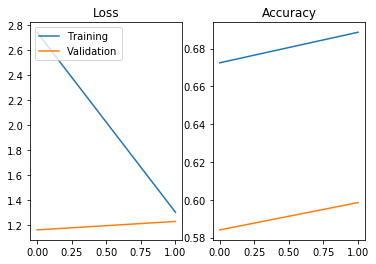

In [80]:
history = model.fit(X_train, y_train,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 1,  
                    validation_split = 0.1,  
                    class_weight = {0: 1, 1: class_weight})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()

In [81]:
score = model.evaluate(X_test, y_test, verbose = 1)  
print('Validation score:', score[0])  
print('Validation accuracy:', score[1])  

29120/29202 [============================>.] - ETA: 0s

In [82]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

28672/29202 [============================>.] - ETA: 0s 

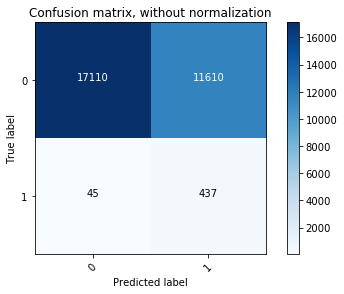

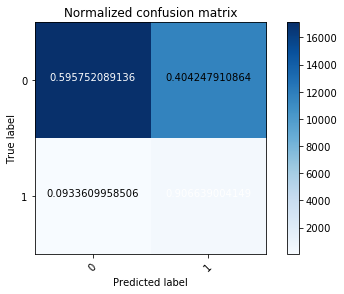

In [83]:
from sklearn.metrics import confusion_matrix
import itertools

y_true = y_test[:,1]
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()

## Testing

In [84]:
path_testing = "capture20110811.binetflow.txt"
df0 = importdata(path_testing)
df = preprocessing(df0)

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          3993
Dir               0
DstAddr           0
Dport          2973
State             0
sTos           4324
dTos         269835
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

Number of Original Dataset : 1808122
Number of Drop NaN : 1534307
Number of Botnet : 7733
Number of Normal : 1526574

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)



Feature Number of Result : 15


In [85]:
column = ['Dur', 'Proto', 'Dir', 'State', 'sTos', 'dTos',
          'TotPkts', 'TotBytes', 'SrcBytes', 'Sport', 'Dport']
result = std_combine(df, column)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


dataset size of result_std : 1534307
feature number of result_std : 15
   StartTime        SrcAddr        DstAddr  label         Dur  Proto     Dir  \
0      58549       1.1.1.45  147.32.84.229      0  134.273853  204.0  191.25   
1     119159    1.11.62.138  147.32.84.229      0    0.000017  204.0  191.25   
2    1216467    1.112.0.241  147.32.84.229      0    8.299317  153.0    0.00   
3     901725   1.112.104.74  147.32.84.229      0    8.170247  153.0    0.00   
4     120986  1.112.111.112  147.32.84.229      0    0.000016  204.0  191.25   

        State  sTos  dTos   TotPkts  TotBytes  SrcBytes       Sport      Dport  
0    9.394737   0.0   0.0  0.000188  0.000012  0.000255  144.821012  51.996109  
1    9.394737   0.0   0.0  0.000063  0.000009  0.000134  169.669261   0.206226  
2  195.947368   0.0   0.0  0.000750  0.000090  0.000468  241.346304  51.996109  
3   81.868421   0.0   0.0  0.000625  0.000144  0.001959    6.435798   0.311284  
4    9.394737   0.0   0.0  0.000063  0.0000

In [86]:
result_mod = mod_pairwise_count(result=result, threshold=10)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


              SrcAddr      DstAddr  count_number
60289   147.32.84.138  147.32.80.9        371143
101328   147.32.84.59  147.32.80.9         73651
116464   147.32.85.25  147.32.80.9         34136
117555   147.32.85.34  147.32.80.9         21637
131480   147.32.86.20  147.32.80.9         10230
Size of pairwise > 10 : 6145
Sum of size of pairwise > 10 : 900808
Size of modifying result  900808


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sort IP
   label       Dur  Proto     Dir      State  sTos  dTos   TotPkts  TotBytes  \
0      0  0.000075  204.0  191.25   9.394737   0.0   0.0  0.000063  0.000005   
1      0  0.000019  204.0  191.25   9.394737   0.0   0.0  0.000063  0.000009   
2      0  0.000022  204.0  191.25   9.394737   0.0   0.0  0.000063  0.000009   
3      0  0.000013  204.0  191.25   9.394737   0.0   0.0  0.000063  0.000009   
4      0  0.049486  153.0    0.00  81.868421   0.0   0.0  0.000563  0.000054   

   SrcBytes       Sport      Dport  
0  0.000131   64.505837  51.996109  
1  0.000138  236.163424   0.206226  
2  0.000134  193.136187   0.206226  
3  0.000134  213.579767   0.206226  
4  0.000809  196.408560   0.311284  


In [90]:
X, Y = reshape2(result=result, result_mod=result_mod, mod_size=900800)

=== Distridution of Botnet ===
0    893669
1      7131
Name: label, dtype: int64
0    89365
1      715
Name: max, dtype: int64
Baseline of Original Dataset 0.9950
Baseline of Reshape Dataset 0.9921
Number of features: 110


In [91]:
X, X_test, input_shape = toimage(X, X_test, img_rows, img_cols)

Shape of training data: (90080, 10, 11, 1)
Shape of testing data: (29202, 10, 11, 1)


89568/90080 [============================>.] - ETA: 0s 

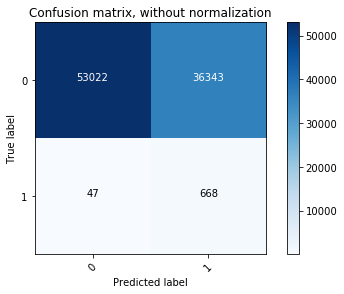

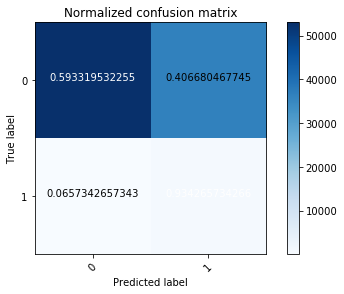

In [92]:
from sklearn.metrics import confusion_matrix
import itertools

y_true = Y[:,1]
y_pred = model.predict_classes(X)
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()